In [1]:
import os, ccdproc
from os import listdir
import numpy as np
import pandas as pd
from pathlib import Path
from utils.correcting import Correcting
from utils.plate_solving import platesolving
from utils.photometry import Photometry
import matplotlib.pyplot as plt
from scipy import optimize

#For isochrones
import read_mist_models # a .py file that needs to be inyour directory like A345_utilities.py

Plate Solving module - Ignore any API key warnings below, they are not important



Correcting and Plate solving 1800x1200 images

In [2]:
size = "1800x1200"
source = "M67"


data_directory = f'/data/observatory/remote_telescope/data/cropped_{size}'
images_directory = f'images/Cluster Photometry/{source}' 
folderpath = os.path.join(data_directory,images_directory)#,image_filter[0])
filenames = [f for f in listdir(folderpath) if f.endswith('.fits')]

filenames.sort()
print (f"Iterating over {len(filenames)} files")
"""
for f in filenames[50:]:
    print (f)
    x = Correcting(size, source, f)
    calib_image = x.correcting()
    platesolving(**calib_image)
"""   

Iterating over 60 files


'\nfor f in filenames[50:]:\n    print (f)\n    x = Correcting(size, source, f)\n    calib_image = x.correcting()\n    platesolving(**calib_image)\n'


Photometry on 3000x3000 images

In [3]:
target = "M67"
size = "3000x3000"

folderpathR = f'/data/observatory/student_data/natalia_bajnokova/{target}/Calibrated_{size}/R/'
folderpathG = f'/data/observatory/student_data/natalia_bajnokova/{target}/Calibrated_{size}/G/'
folderpathI = f'/data/observatory/student_data/natalia_bajnokova/{target}/Calibrated_{size}/I/'


filenames = [folderpathR+f for f in listdir(folderpathR) if f.endswith('.dat')]
filenames+=[folderpathG+f for f in listdir(folderpathG) if f.endswith('.dat')]
filenames+=[folderpathI+f for f in listdir(folderpathI) if f.endswith('.dat')]
filenames.sort()

stars = {}
for file in filenames:
    table = np.genfromtxt(file, names=True,dtype=None)
    path = Path(file)
    filtr = str(path.parent)[-1] #Get filter
    stars = Photometry.stars_list(table, stars, filtr)

In [4]:
diction = {"ra_unrounded": [], "dec_unrounded": [], "ra":[], "dec": [], "Imag_found":[], "Gmag_found":[], "Rmag_found":[], 
           "Imag_full":[], "Gmag_full":[], "Rmag_full":[], "I_flux": [], "G_flux":[], "R_flux":[]}



for obj in stars.values():
    diction["ra_unrounded"].append(np.round(obj.ra, 4))
    diction["dec_unrounded"].append(np.round(obj.dec, 4))
    diction["ra"].append(np.round(obj.ra, 3))
    diction["dec"].append(np.round(obj.dec, 3))
    diction["Imag_found"].append(-2.5*np.log10(obj.i.avg_flux*1.3))
    diction["Gmag_found"].append(-2.5*np.log10(obj.g.avg_flux*1.3))
    diction["Rmag_found"].append(-2.5*np.log10(obj.r.avg_flux*1.3))
    diction["Imag_full"].append([i for i in obj.i.mag])
    diction["Gmag_full"].append([i for i in obj.g.mag])
    diction["Rmag_full"].append([i for i in obj.r.mag])
    diction["I_flux"].append(obj.i.avg_flux*1.3)
    diction["G_flux"].append(obj.g.avg_flux*1.3)
    diction["R_flux"].append(obj.r.avg_flux*1.3)

    

i_flux = []
g_flux= []
r_flux = []
for obj in stars.values(): 

    i_flux.append(obj.i.avg_flux*1.3)
    g_flux.append(obj.g.avg_flux*1.3)
    r_flux.append(obj.r.avg_flux*1.3)
    
print(len(diction["R_flux"]) + len(diction["I_flux"]) + len(diction["G_flux"]))
print (len(diction["Imag_found"]) + len(diction["Gmag_found"])+ len(diction["Rmag_found"]))

2742
2742


<ipython-input-4-7f5ea0479e7f>:13: RuntimeWarning: divide by zero encountered in log10
  diction["Rmag_found"].append(-2.5*np.log10(obj.r.avg_flux*1.3))
<ipython-input-4-7f5ea0479e7f>:11: RuntimeWarning: divide by zero encountered in log10
  diction["Imag_found"].append(-2.5*np.log10(obj.i.avg_flux*1.3))
<ipython-input-4-7f5ea0479e7f>:11: RuntimeWarning: invalid value encountered in log10
  diction["Imag_found"].append(-2.5*np.log10(obj.i.avg_flux*1.3))
<ipython-input-4-7f5ea0479e7f>:13: RuntimeWarning: invalid value encountered in log10
  diction["Rmag_found"].append(-2.5*np.log10(obj.r.avg_flux*1.3))
<ipython-input-4-7f5ea0479e7f>:12: RuntimeWarning: invalid value encountered in log10
  diction["Gmag_found"].append(-2.5*np.log10(obj.g.avg_flux*1.3))
<ipython-input-4-7f5ea0479e7f>:12: RuntimeWarning: divide by zero encountered in log10
  diction["Gmag_found"].append(-2.5*np.log10(obj.g.avg_flux*1.3))


Calibrating with carlibration stars

In [5]:
calibration_file = '/data/observatory/student_data/Alasdairs File/M67_Calibration_Star_List.csv'

#col_names=['Full', 'RAJ2000 deg', 'DEJ2000 deg', 'VTmag mag', "gmag mag", "rmag mag", "imag mag", "ok"]
calibstar_all = pd.read_csv(calibration_file)
calibstar_all = calibstar_all.round({'RAJ2000': 3, 'DEJ2000': 3})

#calibstars = calibstar_all.loc[calibstar_all['ok'] == 1]
calibstars =calibstar_all.round({'RAJ2000': 3, 'DEJ2000': 3})


In [6]:
platesovled_stars = pd.DataFrame(data = diction)

import pprint

merged = pd.merge(calibstar_all, platesovled_stars, how='inner', left_on=['RAJ2000', 'DEJ2000'], right_on=['ra', 'dec'])
pp = pprint.PrettyPrinter(width=41, compact=True)
pp.pprint(calibstars)
#pp.pprint(merged)

     Full  RAJ2000  DEJ2000   VTmag    gmag    rmag    imag     ok
0       1  132.821   11.846  11.095  11.617  10.748  10.526  0.067
1       2  132.942   11.605  11.166  11.563  10.968  10.840  0.023
2       3  132.837   11.891  11.248  11.436  11.143  11.188  0.082
3       4  132.707   11.586  11.266  11.892  10.920  10.711  0.025
4       5  132.860   11.731  11.273  11.341  11.355  11.591  0.031
..    ...      ...      ...     ...     ...     ...     ...    ...
195   196  133.014   11.968  13.990  14.270  13.802  13.697  0.098
196   197  132.801   11.844  13.994  14.521  13.765  13.953  0.094
197   198  132.833   11.839  14.001  14.373  13.859  13.942  0.086
198   199  132.986   11.803  14.007  14.295  13.852  13.748  0.062
199   200  132.893   11.847  14.016  14.196  14.541  13.590  0.000

[200 rows x 8 columns]


Getting best fit lines

[[1.3301568367553642, 1.3593357552068586, 1.4823091069560483, 1.4132897180490982, 1.2866733677149629, 1.2269919487439935, 1.3681470724264884, 1.3647231040702898, 1.3991453912865897, 1.2563623448017047, 1.3065863597137692, 1.4840216846791208, 1.7103111499483568, 2.0173050717510037, 2.079014608135944, 1.8465446675400727, 1.69729209225987, 1.6134005490480305, 1.3579909323028865, 1.3597430915558988, 1.9170554977043963, 2.237093425979012, 0.5939310492383374, -0.008031066947156162, -0.04616707448125368, -0.030470343155961643, 0.017806603210553718, -0.06093571515772922, 0.06459767575790032, -0.18843919696635147, -0.18891801223296056, -0.18937860427155329, -0.1833909881942617, -0.20025610086030454, -0.20337933611957837, -0.1985821593646655, -0.19346789538389508, -0.1902896613491727, -0.16427992703242822, -0.179884197683311, -0.17675371745153612, -0.17444602032743006, -0.16399839301140418, -0.16075963751796074, -0.15334767563064133, -0.15216195064210147, -0.1469569486252773, -0.1851843086790126

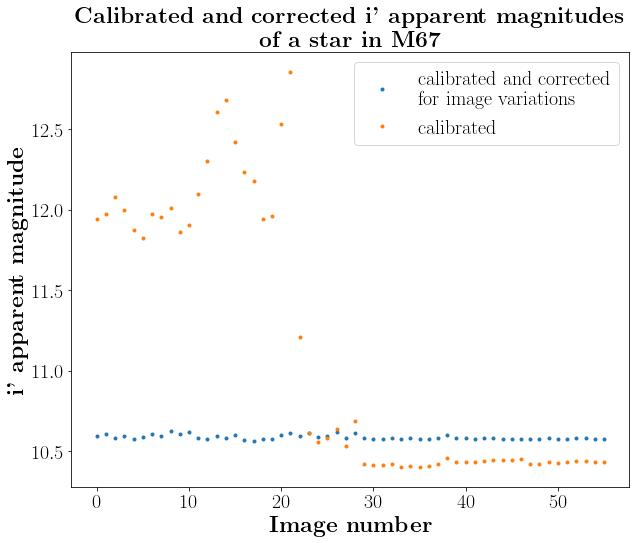

In [9]:
def linear (x, m, k):
    return (m*x + k)

def get_range(array):
    a_range = np.linspace(np.min(array), np.max(array), 1000)
    return a_range

r_params, r_params_covariance = optimize.curve_fit(linear, merged["Rmag_found"], merged["rmag"])
r_m = r_params[0]
r_k = r_params[1]
r_m_e = np.sqrt(np.diag(r_params_covariance))[0]
r_k_e = np.sqrt(np.diag(r_params_covariance))[1]



g_params, g_params_covariance = optimize.curve_fit(linear, merged["Gmag_found"], merged["gmag"])
g_m = g_params[0]
g_k = g_params[1]
g_m_e = np.sqrt(np.diag(g_params_covariance))[0]
g_k_e = np.sqrt(np.diag(g_params_covariance))[1]


i_params, i_params_covariance = optimize.curve_fit(linear, merged["Imag_found"], merged["imag"])
i_m = i_params[0]
i_k = i_params[1]
i_m_e = np.sqrt(np.diag(i_params_covariance))[0]
i_k_e = np.sqrt(np.diag(i_params_covariance))[1]

I_corrected = []
class Corrected:
    def __init__(self, real):
        self.real = real
        self.mag = []
        self.corrected_var = []
        self.residual_var = []
    def add(self, mag):
        self.mag.append(mag)
        self.residual_var.append([i - self.real for i in mag])
        
    def corrected_residual(self,v):
        
        self.corrected_var.append(v)
        
        
        

I_corrected = []
for index, row in merged.iterrows():
    a = Corrected(row["imag"])
    a.add([i_m*e + i_k for e in row["Imag_full"]])
    I_corrected.append(a)

Img = np.array([])

for row in I_corrected:
   
    if Img.size == 0:
        Img = np.append(Img, row.residual_var[0])
        
    else:
        Img = np.vstack((Img, row.residual_var[0]))

    
    
r = [np.mean(Img[:,i]) for i in range(len(Img[0]))]

for i in range(len(r)):
    var = r[i]
    for row in I_corrected:
        v = row.mag[0][i] - var
        row.corrected_residual(v)
    
#f = Img[:,0]-r
#m = np.std(f)
print (I_corrected[7].residual_var)
stds = [np.std(I_corrected[i].corrected_var) for i in range(len(I_corrected))]
star0 = I_corrected[0].corrected_var
star0_uncorrected = I_corrected[0].mag
star1 = I_corrected[1].corrected_var
star2 = I_corrected[2].corrected_var

#print(star0)
#print (std_i)
#print (np.std(I_corrected[0][25:] - merged["imag"][0]))
#print (np.std(I_corrected[0][25:] - merged["imag"][0]))
#print (merged["Imag_full"][0])
i = range(len(star0))
plt.figure(figsize=[10,8])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=23)     # fontsize of the axes title
plt.rc('axes', labelsize=23)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.plot(i, star0, ".", label="calibrated and corrected \n for image variations")
plt.plot(i, star0_uncorrected[0], ".", label=r"calibrated")
#plt.plot(i, merged["Imag_full"][0], ".", label="instrumental magnitude")
#plt.plot(i, star0 - merged["imag"][0], ".", label="star 1")
#plt.plot(i, star1 - merged["imag"][1], ".", label="star 2")
#plt.plot(i, star2 - merged["imag"][2], ".", label="star 3")
#plt.plot(stds, ".")
plt.xlabel(r"\textbf{Image number}")
plt.ylabel(r"\textbf{i' apparent magnitude}")
plt.title(r"\textbf{Calibrated and corrected i' apparent magnitudes}"+ 
          "\n"+
          r"\textbf{of a star in M67}")
plt.legend()
plt.savefig("image_var.png")
print(stds/merged["imag"])

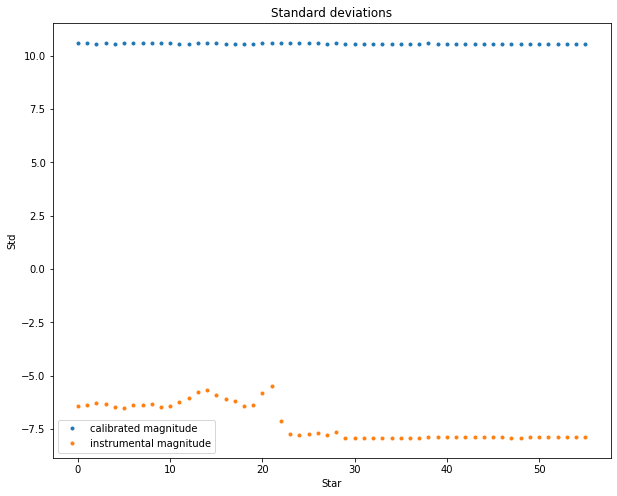

In [11]:
G_corrected = []

for index, row in merged.iterrows():
    a = Corrected(row["gmag"])
    a.add([g_m*e + g_k for e in row["Gmag_full"]])
    G_corrected.append(a)

ImgG = np.array([])

for row in G_corrected:
   
    if ImgG.size == 0:
        ImgG = np.append(ImgG, row.residual_var[0])
        
    else:
        ImgG = np.vstack((ImgG, row.residual_var[0]))

    
    
g = [np.mean(ImgG[:,i]) for i in range(len(ImgG[0]))]

for i in range(len(g)):
    var = g[i]
    for row in G_corrected:
        v = row.mag[0][i] - var
        row.corrected_residual(v)
    
stdsG = [np.std(G_corrected[i].corrected_var) for i in range(len(G_corrected))]

R_corrected = []

for index, row in merged.iterrows():
    a = Corrected(row["rmag"])
    a.add([r_m*e + r_k for e in row["Rmag_full"]])
    R_corrected.append(a)

ImgR = np.array([])

for row in R_corrected:
   
    if ImgR.size == 0:
        ImgR = np.append(ImgR, row.residual_var[0])
        
    else:
        ImgR = np.vstack((ImgR, row.residual_var[0]))

    
    
r = [np.mean(ImgR[:,i]) for i in range(len(ImgR[0]))]

for i in range(len(r)):
    var = g[i]
    for row in R_corrected:
        v = row.mag[0][i] - var
        row.corrected_residual(v)
    

stdsR = [np.std(R_corrected[i].corrected_var) for i in range(len(R_corrected))]


i = range(len(star0))
plt.figure(figsize=[10,8])
plt.plot(i, star0, ".", label="calibrated magnitude")
#plt.plot(i, merged["Imag_full"][0], ".", label="instrumental magnitude")
#plt.plot(i, star0 - merged["imag"][0], ".", label="star 1")
#plt.plot(i, star1 - merged["imag"][1], ".", label="star 2")
#plt.plot(i, star2 - merged["imag"][2], ".", label="star 3")
#plt.plot(stdsG, ".", label="G-filter stds")
#plt.plot(stds, ".", label="I-filter stds")
#plt.plot(stdsR, ".", label="R")
plt.xlabel("Star")
plt.ylabel("Std")
plt.title("Standard deviations")
plt.legend()
#plt.savefig("stds.png")
plt.show()

In [9]:
g_error_calib = (1.0857/np.sqrt(merged["G_flux"])) 
r_error_calib = (1.0857/np.sqrt(merged["R_flux"]))
i_error_calib = (1.0857/np.sqrt(merged["I_flux"]))

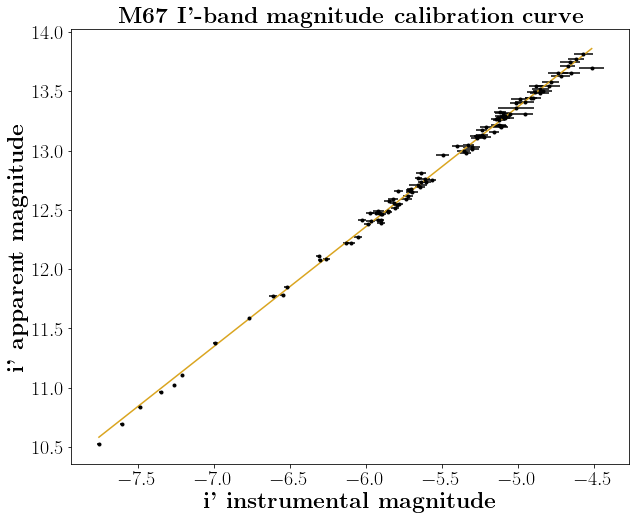

In [39]:
plt.figure(figsize=[10,8])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=23)     # fontsize of the axes title
plt.rc('axes', labelsize=23)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=23)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

plt.errorbar(merged["Imag_found"], merged["imag"], xerr = stds, fmt="k.")
plt.plot(get_range(merged["Imag_found"]), linear(get_range(merged["Imag_found"]), i_m, i_k), "goldenrod")

plt.title(r"\textbf{M67 I'-band magnitude calibration curve}")
plt.ylabel(r"\textbf{i' apparent magnitude}")
plt.xlabel(r"\textbf{i' instrumental magnitude}")
plt.savefig("M67_calibration_curve.png")

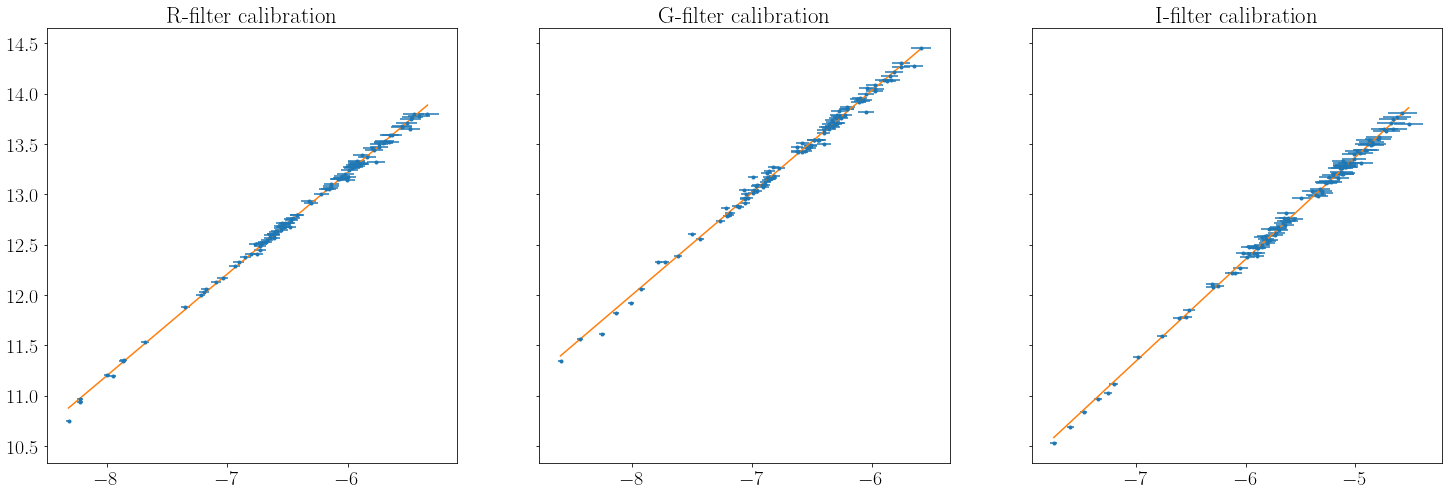

In [43]:
f, (ax_r, ax_g, ax_i) = plt.subplots(1, 3, sharey=True, figsize=(25,8))
ax_r.errorbar(merged["Rmag_found"], merged["rmag"], xerr = r_error_calib, fmt=".")
ax_r.plot(get_range(merged["Rmag_found"]), linear(get_range(merged["Rmag_found"]), r_m, r_k))

ax_g.errorbar(merged["Gmag_found"], merged["gmag"], xerr = g_error_calib, fmt=".")
ax_g.plot(get_range(merged["Gmag_found"]), linear(get_range(merged["Gmag_found"]), g_m, g_k))

ax_i.errorbar(merged["Imag_found"], merged["imag"], xerr = i_error_calib, fmt=".")
ax_i.plot(get_range(merged["Imag_found"]), linear(get_range(merged["Imag_found"]), i_m, i_k))

ax_r.set_title("R-filter calibration")
ax_g.set_title("G-filter calibration")
ax_i.set_title("I-filter calibration")
plt.show()

In [44]:
g_mag_uncorrected = -2.5*np.log10(g_flux)
r_mag_uncorrected = -2.5*np.log10(r_flux)
i_mag_uncorrected = -2.5*np.log10(i_flux)


g_mag_corrected = linear(g_mag_uncorrected, g_m, g_k)
i_mag_corrected = linear(i_mag_uncorrected, i_m, i_k)
r_mag_corrected = linear(r_mag_uncorrected, r_m, r_k)

g_mag_corrected_max = linear(g_mag_uncorrected, g_m+g_m_e, g_k+g_k_e)
i_mag_corrected_max = linear(i_mag_uncorrected, i_m+i_m_e, i_k+i_k_e)
r_mag_corrected_max = linear(r_mag_uncorrected, r_m+r_m_e, r_k+r_m_e)

#g_error_corrected = np.sqrt((1.0857/np.sqrt(g_flux))**2 + linear(g_mag_corrected, g_m_e, g_k_e)**2)
#i_error_corrected = (1.0857/np.sqrt(i_flux))**2 + linear(i_mag_corrected, i_m_e, i_k_e)**2
#r_error_corrected = (1.0857/np.sqrt(r_flux))**2 + linear(r_mag_corrected, r_m_e, r_k_e)**2

gi = np.subtract(g_mag_corrected,i_mag_corrected)
gr = np.subtract(g_mag_corrected,r_mag_corrected)
ri = np.subtract(r_mag_corrected,i_mag_corrected)

g_mag_callibration = linear(merged["Gmag_found"], g_m, g_k)
i_mag_callibration = linear(merged["Imag_found"], i_m, i_k)
r_mag_callibration = linear(merged["Rmag_found"], r_m, r_k)

gi_max = np.subtract(g_mag_corrected_max,i_mag_corrected_max)
gr_max = np.subtract(g_mag_corrected_max,r_mag_corrected_max)
ri_max = np.subtract(r_mag_corrected_max,i_mag_corrected_max)

gi_callibration = np.subtract(g_mag_callibration,i_mag_callibration)
gr_callibration = np.subtract(g_mag_callibration,r_mag_callibration)
ri_callibration = np.subtract(r_mag_callibration,i_mag_callibration)

<ipython-input-44-eece20f382e6>:1: RuntimeWarning: divide by zero encountered in log10
  g_mag_uncorrected = -2.5*np.log10(g_flux)
<ipython-input-44-eece20f382e6>:1: RuntimeWarning: invalid value encountered in log10
  g_mag_uncorrected = -2.5*np.log10(g_flux)
<ipython-input-44-eece20f382e6>:2: RuntimeWarning: divide by zero encountered in log10
  r_mag_uncorrected = -2.5*np.log10(r_flux)
<ipython-input-44-eece20f382e6>:2: RuntimeWarning: invalid value encountered in log10
  r_mag_uncorrected = -2.5*np.log10(r_flux)
<ipython-input-44-eece20f382e6>:3: RuntimeWarning: divide by zero encountered in log10
  i_mag_uncorrected = -2.5*np.log10(i_flux)
<ipython-input-44-eece20f382e6>:3: RuntimeWarning: invalid value encountered in log10
  i_mag_uncorrected = -2.5*np.log10(i_flux)
<ipython-input-44-eece20f382e6>:18: RuntimeWarning: invalid value encountered in subtract
  gi = np.subtract(g_mag_corrected,i_mag_corrected)
<ipython-input-44-eece20f382e6>:19: RuntimeWarning: invalid value encounter

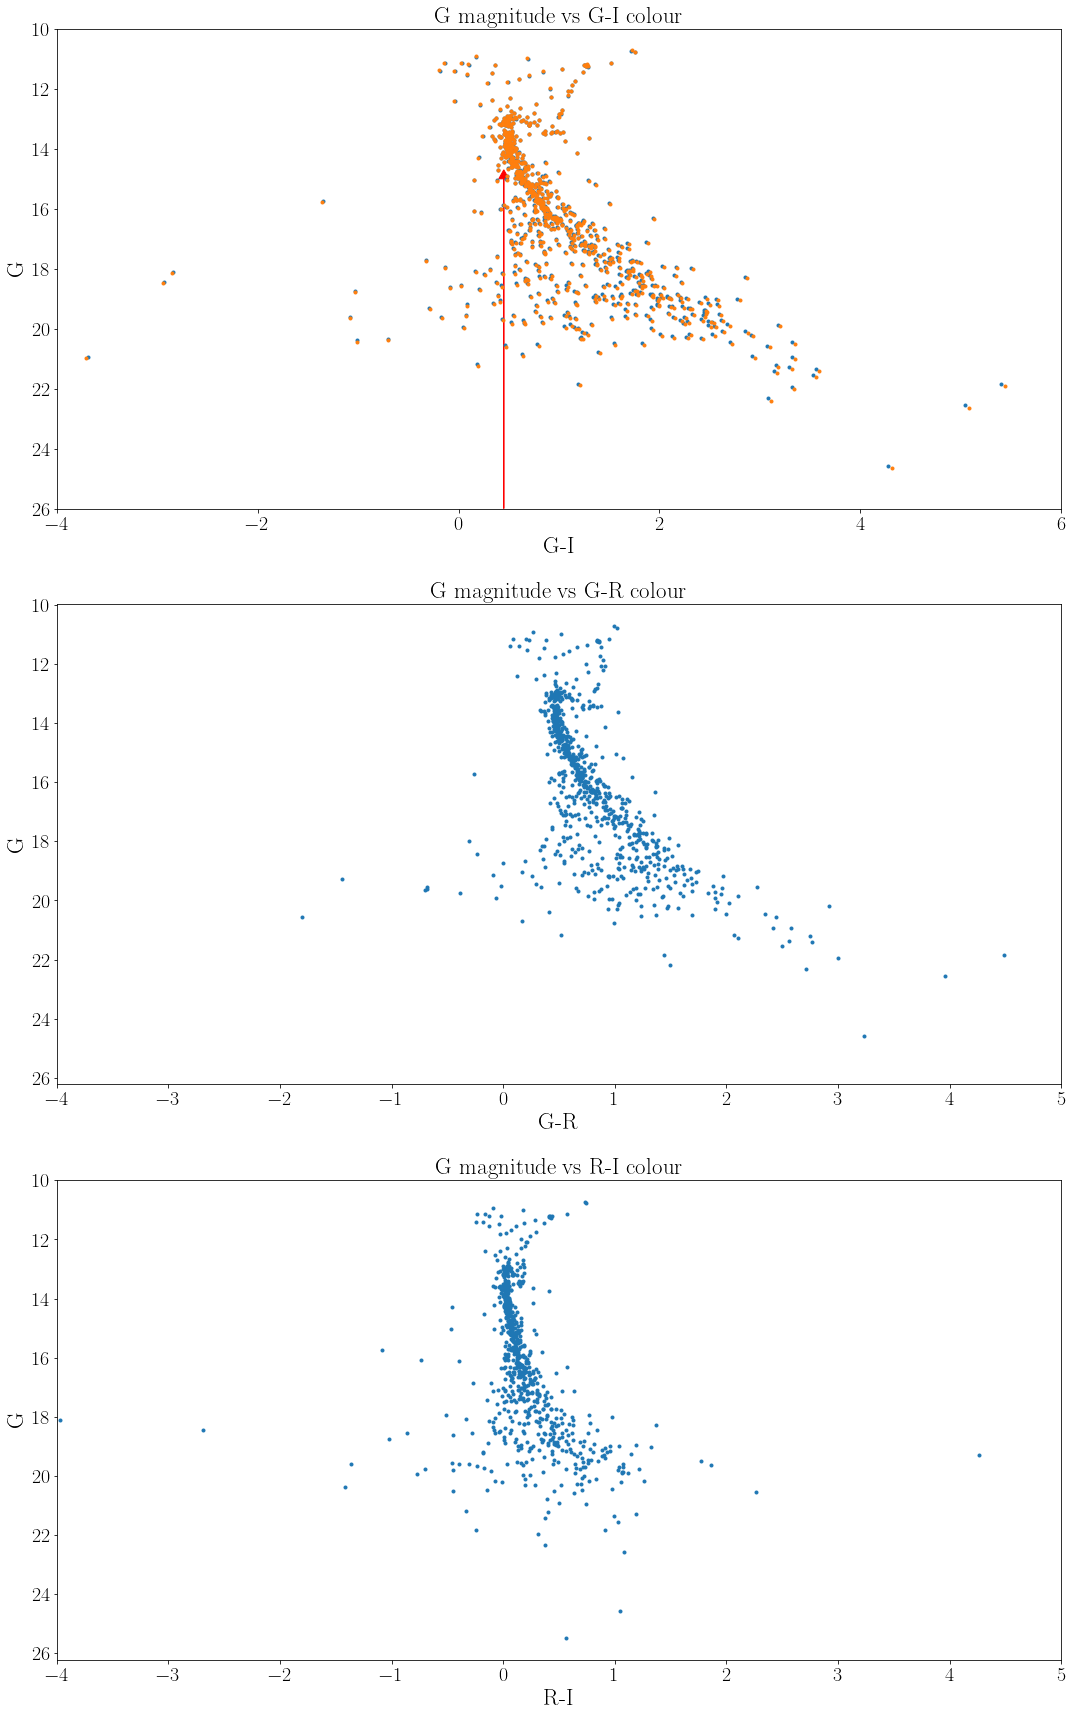

In [45]:
arrowprops = {'width': 1, 'headwidth': 1, 'headlength': 0.4, 'shrink':0.05}

plt.figure(figsize=[18,30])
plt.subplot(311)
plt.plot(gi, g_mag_corrected, ".")
plt.plot(gi_max, g_mag_corrected_max, ".")
plt.xlim([-4, 6])
plt.ylim([10, 26])
plt.xlabel("G-I")
plt.ylabel("G")
plt.arrow(0.45,26,0,-11, head_width=0.1, head_length=0.3, color = "r")
plt.title("G magnitude vs G-I colour")
plt.gca().invert_yaxis()

plt.subplot(312)
plt.plot(gr, g_mag_corrected, ".")
plt.xlabel("G-R")
plt.ylabel("G")
plt.xlim([-4, 5])
plt.title("G magnitude vs G-R colour")
plt.gca().invert_yaxis()

plt.subplot(313)
plt.plot(ri, g_mag_corrected, ".")
plt.xlim([-4, 5])
#plt.ylim([6, 18])
plt.xlabel("R-I")
plt.ylabel("G")
plt.title("G magnitude vs R-I colour")
plt.gca().invert_yaxis()

plt.savefig("M67_ColourPlots_vs_Gmag_Small.png")

In [46]:
star_catalogue_dict = {'RA':diction["ra_unrounded"], 'DEC':diction["dec_unrounded"], 'G apparent magnitude': g_mag_corrected, 
                       'I apparent magnitude': i_mag_corrected, 'R apparent magnitude': r_mag_corrected}

star_catalogue =  pd.DataFrame(data = star_catalogue_dict)

#mask_i = star_catalogue['I apparent magnitude'].map(safe_float_convert)
#print (mask_i)
#mask_r = star_catalogue['R apparent magnitude'].map(safe_float_convert)
#mask_g = star_catalogue['G apparent magnitude'].map(safe_float_convert)
filteredR_nan = star_catalogue.loc[np.isnan(star_catalogue['R apparent magnitude']) == False].copy()
filteredG_nan = filteredR_nan.loc[np.isnan(filteredR_nan['G apparent magnitude']) == False].copy()
filteredI_nan = filteredG_nan.loc[np.isnan(filteredG_nan['I apparent magnitude']) == False].copy()

filteredR_inf = filteredI_nan.loc[np.isinf(filteredI_nan['R apparent magnitude']) == False].copy()
filteredG_inf = filteredR_inf.loc[np.isinf(filteredR_inf['G apparent magnitude']) == False].copy()
filteredI_inf = filteredG_inf.loc[np.isinf(filteredG_inf['I apparent magnitude']) == False].copy()

#filteredI_inf.drop(filteredI_inf.columns[0], inplace=True, axis = 1) 

#filteredI_inf.to_csv('star_catalogue_M67.csv')

#df = pd.read_csv('star_catalogue_M67.csv', usecols=['RA', 'DEC', 'G apparent magnitude', 'R apparent magnitude', 'I apparent magnitude'])
#print (df)
#df.to_csv('catalogue_M67.csv')

In [47]:
ar = np.column_stack((filteredI_inf["RA"],filteredI_inf["DEC"]))
df = pd.DataFrame(filteredI_inf, columns = ['RA', 'DEC'])
print (df.dtypes)
#df.to_csv('gaia_files.txt', index = False)
#df.to_csv('gaia_files.txt', index = False, sep='+')
#np.savetxt("gaia_files.txt", ar, delimiter=' ')

RA     float64
DEC    float64
dtype: object


0.13627592375483125
97.30923035851777
1.1172247188971156


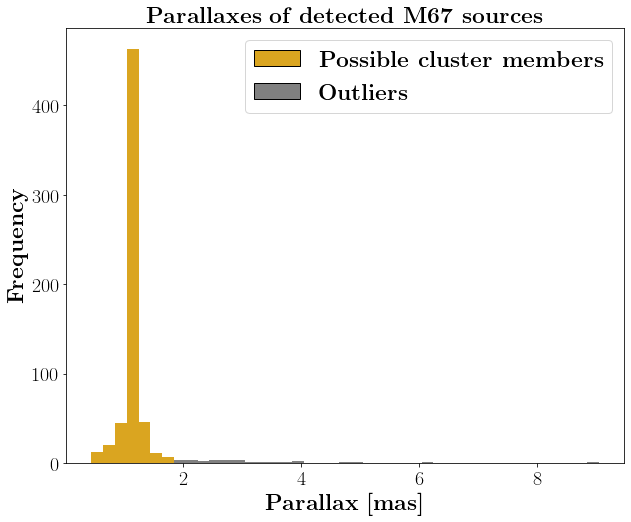

In [48]:
from astropy.io.votable import parse
import pandas as pd
from matplotlib.patches import Rectangle

def votable_to_pandas(votable_file):
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()




d = votable_to_pandas('parallaxes_M67_1sec.vot')
d['parallax_error_percentage'] = d['parallax_error']/d['parallax']

parallax_real = d.loc[(d['parallax']>0) & (d['parallax_error_percentage']< 0.1)]


parallax_restricted = parallax_real[parallax_real['parallax']<1.4]
parallax = np.mean(parallax_restricted['parallax'])

parallax_std = np.std(parallax_restricted['parallax'])

parallax_number = len(parallax_restricted['parallax'])

d1 = votable_to_pandas('parallaxes_M67.vot')
#parallax = np.mean(d['parallax'])

parallax1 = np.mean(d1['parallax'])
plt.figure(figsize=[10,8])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=23)     # fontsize of the axes title
plt.rc('axes', labelsize=23)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=23)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
N, bins, patches = plt.hist(parallax_real['parallax'], bins=np.arange(min(parallax_real['parallax']), max(parallax_real['parallax']) + 0.2, 0.2))
#plt.hist(d1['parallax'], bins = 50)
plt.title(r'\textbf{Parallaxes of detected M67 sources}')
plt.xlabel(r'\textbf{Parallax [mas]}')
plt.ylabel(r'\textbf{Frequency}')

for i in range(0,7):
    patches[i].set_facecolor('goldenrod')
for i in range(7,43):    
    patches[i].set_facecolor('gray')
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['goldenrod','gray']]
labels= [r'\textbf{Possible cluster members}',r'\textbf{Outliers}']
plt.legend(handles, labels)
    
plt.savefig('histogram_M67.png')
#plt.show()

d = 1000/parallax
print (parallax_std)
print (d - 1000/(parallax+ parallax_std))
print (parallax)

Fitting isochrones

In [49]:
isocmd = read_mist_models.ISOCMD('MIST_iso_604a1d34154e3.iso.cmd')

print ('version: ', isocmd.version)
print ('photometric system: ', isocmd.photo_sys)
print ('abundances: ', isocmd.abun)
print ('rotation: ', isocmd.rot)
print ('ages: ', [round(x,2) for x in isocmd.ages])
print ('number of ages: ', isocmd.num_ages)
print ('available columns: ', isocmd.hdr_list)
print ('Av extinction: ', isocmd.Av_extinction)

Reading in: MIST_iso_604a1d34154e3.iso.cmd
version:  {'MIST': '1.2', 'MESA': '7503'}
photometric system:  SDSS (AB)
abundances:  {'Yinit': 0.2703, 'Zinit': 0.0142, '[Fe/H]': 0.0, '[a/Fe]': 0.0}
rotation:  0.4
ages:  [5.0, 5.05, 5.1, 5.15, 5.2, 5.25, 5.3, 5.35, 5.4, 5.45, 5.5, 5.55, 5.6, 5.65, 5.7, 5.75, 5.8, 5.85, 5.9, 5.95, 6.0, 6.05, 6.1, 6.15, 6.2, 6.25, 6.3, 6.35, 6.4, 6.45, 6.5, 6.55, 6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05, 7.1, 7.15, 7.2, 7.25, 7.3, 7.35, 7.4, 7.45, 7.5, 7.55, 7.6, 7.65, 7.7, 7.75, 7.8, 7.85, 7.9, 7.95, 8.0, 8.05, 8.1, 8.15, 8.2, 8.25, 8.3, 8.35, 8.4, 8.45, 8.5, 8.55, 8.6, 8.65, 8.7, 8.75, 8.8, 8.85, 8.9, 8.95, 9.0, 9.05, 9.1, 9.15, 9.2, 9.25, 9.3, 9.35, 9.4, 9.45, 9.5, 9.55, 9.6, 9.65, 9.7, 9.75, 9.8, 9.85, 9.9, 9.95, 10.0, 10.05, 10.1, 10.15, 10.2, 10.25, 10.3]
number of ages:  107
available columns:  ['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'SDSS_u', 'SDSS_g', 'SDSS_r',

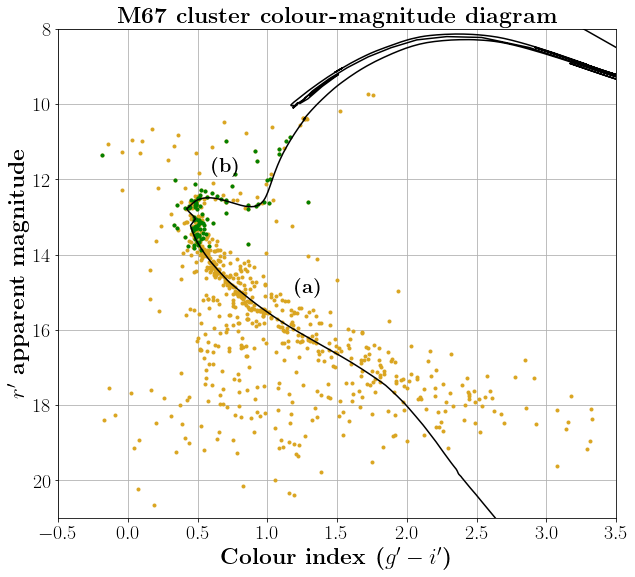

In [50]:
fig, ax = plt.subplots(figsize=(10,9))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=23)     # fontsize of the axes title
plt.rc('axes', labelsize=23)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=23)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
age_ind = isocmd.age_index(9.7) # A guess at the cluster age, turning point, to be refined to fit data
age_ind_1 = isocmd.age_index(10)

G = isocmd.isocmds[age_ind]['SDSS_g']
R = isocmd.isocmds[age_ind]['SDSS_r']
I = isocmd.isocmds[age_ind]['SDSS_i']

G1 = isocmd.isocmds[age_ind_1]['SDSS_g']
R1 = isocmd.isocmds[age_ind_1]['SDSS_r']
I1 = isocmd.isocmds[age_ind_1]['SDSS_i']

ax.annotate(r'\textbf{(a)}', xy=(1.2, 15), xytext=(1.2, 15), fontsize=20)
ax.annotate(r'\textbf{(b)}', xy=(0.6, 11.8), xytext=(0.6, 11.8), fontsize=20)
plt.plot(gi, r_mag_corrected, ".", color = "goldenrod")
#plt.plot(G1-I1, R1+9) # the distance modulus mu=m-M, scales the isochrone data from absolute to apparant magnitude and thus gives distance, a guess to be refined to fit data
plt.plot(gi_callibration, r_mag_callibration, "g.")
plt.plot(G-I+0.035, R+9.55, "k", label = "Theoretical isochrone") # the distance modulus mu=m-M, scales the isochrone data from absolute to apparant magnitude and thus gives distance, a guess to be refined to fit data
plt.xlabel(r'\textbf{Colour index ($g^\prime-i^\prime$)}')
plt.ylabel(r'\textbf{$r^\prime$ apparent magnitude}')
plt.title(r'\textbf{M67 cluster colour-magnitude diagram}')
plt.grid()
plt.axis([-0.5, 3.5, 21, 8])
plt.savefig("CMD_M67.png")

In [116]:
d_modulus = 10**(9.55/5 +1)
print (d_modulus)
print (10**9.7)

error_d = 10**(0.5/5 +1)
error_a = 10**0.2
print (error_d)
print (error_a)

812.8305161640995
5011872336.272715
12.589254117941675
1.5848931924611136


In [136]:
print (10**0.1)
print (10**8.9)
print (10**8.10)

1.2589254117941673
794328234.7242821
125892541.17941661


Get reference list for Gaia data

In [17]:
gaia = np.genfromtxt(f'/data/observatory/student_data/natalia_bajnokova/M67/Calibrated_3000x3000/data_cluster_stars.dat', names=True,dtype=None)
a = np.column_stack((gaia["RA"],gaia["DEC"]))
print (a)
#np.savetxt("gaia_files_M67.txt", a, delimiter='+', fmt="%s")



[[132.62746452  11.71099601]
 [132.89991568  11.71077319]
 [133.00386212  11.97731445]
 ...
 [132.86159484  11.81107876]
 [132.80269471  11.87827693]
 [132.98311543  11.85716116]]
